In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.cluster import MiniBatchKMeans




def get_windows(job,n_neighbors):
    '''
    For each region and each individual cell in dataset, return the indices of the nearest neighbors.
    
    'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
    n_neighbors:  the number of neighbors to find for each cell
    '''
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

#     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values) # euclidean_distance, minkowski distance computation
    m = fit.kneighbors(to_fit) # once model has learnt about the distances from above step and indexed them, it can efficiently look through the cells and figure out which are neighbors
#     m = m[0][:,1:], m[1][:,1:]
    m = m[0], m[1]
    

    #sort_neighbors
    args = m[0].argsort(axis = 1) # sorting the cells from nearest to farthest from a specific cell
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


In [2]:
ks = [5,10,15,20] # k=5 means it collects 5 nearest neighbors for each center cell
path_to_data = 'NN_analysis_dataframes_ROI_113023.csv'
X = 'X'
Y = 'Y'
reg = 'ROI_ID'
file_type = 'csv'

cluster_col = 'final_cellType'
keep_cols = [X,Y,reg,cluster_col]
save_path = ''

In [3]:
#read in data and do some quick data rearrangement
n_neighbors = max(ks)
assert (file_type=='csv' or file_type =='pickle') #


if file_type == 'pickle':
    cells = pd.read_pickle(path_to_data)
if file_type == 'csv':
    cells = pd.read_csv(path_to_data)

cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])], axis=1)


#cells = cells.reset_index() #Uncomment this line if you do any subsetting of dataframe such as removing dirt etc or will throw error at end of next next code block (cell 6)

sum_cols = cells[cluster_col].unique() # pulling out unique cell types in the data frame
values = cells[sum_cols].values # getting the true/false values only of the cell types which were added to cells dataframe in the get_dummies step

In [4]:
#find windows for each cell in each tissue region
tissue_group = cells[[X,Y,reg]].groupby(reg) # a separate dataframe of X,Y coordinates and which ROIs the cells are coming from
exps = list(cells[reg].unique()) # list of the unique ROIs from different tissues

# a list of tuples containing information like ROI, indices of cells associated with each ROI
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 

# list of indices where each cell and its nearest 19 sorted neighbors are in one 'row', by sorted I mean closest neighbor to farthest neighbor
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]


Starting: 18/29 : ROI_Tumor1_01S_1711_E
Finishing: 18/29 : ROI_Tumor1_01S_1711_E 6.031136751174927 6.031888961791992
Starting: 9/29 : ROI_Tumor1_03S_10865_H
Finishing: 9/29 : ROI_Tumor1_03S_10865_H 2.1663460731506348 8.268932819366455
Starting: 6/29 : ROI_Tumor1_03S_4794_N
Finishing: 6/29 : ROI_Tumor1_03S_4794_N 0.8850381374359131 9.173227071762085
Starting: 29/29 : ROI_Tumor1_04S_12960_F
Finishing: 29/29 : ROI_Tumor1_04S_12960_F 5.925441026687622 15.107088804244995
Starting: 14/29 : ROI_Tumor1_99S_16874_G
Finishing: 14/29 : ROI_Tumor1_99S_16874_G 6.509911060333252 21.672980070114136
Starting: 22/29 : ROI_Tumor1_S01_573_E
Finishing: 22/29 : ROI_Tumor1_S01_573_E 1.056311845779419 22.788127899169922
Starting: 5/29 : ROI_Tumor1_S02_26957_H
Finishing: 5/29 : ROI_Tumor1_S02_26957_H 4.486077785491943 27.28540802001953
Starting: 8/29 : ROI_Tumor1_S06_05608_B5
Finishing: 8/29 : ROI_Tumor1_S06_05608_B5 3.8687098026275635 31.200562953948975
Starting: 26/29 : ROI_Tumor1_S07_03744_B1
Finishing: 26

In [5]:
#for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
# it can iterate through different Ks now since we already calculated the max K value neighbors and sorted and stored them
# so for k=5, we can just ask for the first 5 neighbors out of the 20 we already calculated

out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)

#concatenate the summed windows and combine into one dataframe for each window size tested.
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],axis=0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],axis=1)
    windows[k] = window


In [ ]:
################ DO NOT RUN THIS CODE BLOCK ################

# silhouette score calculations for each k and n_neighborhoods combination
# ran this on cerberus and then copied the output to my local machine to plot
# finally chose K = 5 and n_neighborhoods = 15

ks=[5]
n_neighborhoods = [5]
import sklearn.metrics as sk

scores_extended = []
for k in ks:
    for n in n_neighborhoods:
        windows_kn = windows[k]
# windows2[cluster_col] = cells[cluster_col]

        km = MiniBatchKMeans(n_clusters = n,random_state=0)

        labelskm = km.fit_predict(windows_kn[sum_cols].values)
        score = sk.silhouette_score(windows_kn.iloc[:,4:] , labelskm, metric='euclidean', sample_size=100000, random_state=1234)   
        scores_extended.append((k,n,score))

scores_extended
#scores = pd.DataFrame(scores,columns=['k','n','score'])
#scores.to_csv('silhouette_scores.csv',index=False)


       

In [6]:
k = 5
n_neighborhoods = 15
neighborhood_name = "neighborhood"+str(n_neighborhoods)
k_centroids = {}

In [7]:
windows5 = windows[k]
# windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labelskm = km.fit_predict(windows5[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells['neighborhood15'] = labelskm
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
#['reg064_A','reg066_A','reg018_B','reg023_A']


/Users/dabkek/miniconda3/envs/akoya_analysis2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [8]:
cell_order = ['Helper T cells', 'M1 Macrophages', 
              'Positive_both', 'Negative_both', 'Tregs', 'Fibroblasts',
              'Only ERAP1+', 'Endothelial cells', 'M2 Macrophages', 'Smooth muscle cells',
              'Only STING+', 'Cytotoxic T cells', 'B cells']

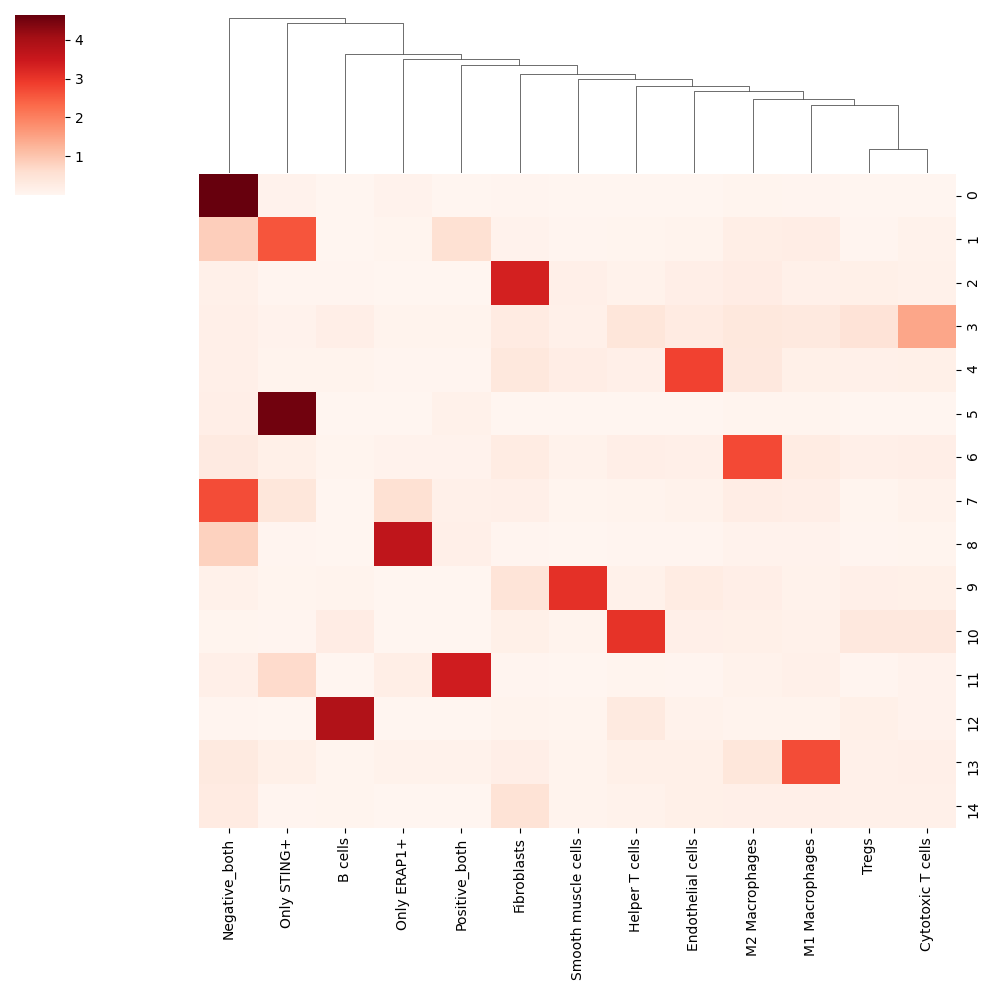

In [9]:
# this plot shows the types of cells (ClusterIDs) in the different niches (0-7)
import seaborn as sns

k_to_plot = 5
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0) # avergae number of cells of each type across all ROIs
fc = niche_clusters
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],cell_order],cmap = 'Reds',row_cluster = False)
# s.savefig("raw_figs/celltypes_perniche_10.pdf")

In [ ]:
label_to_color = {0: '#1F9698',
 1: '#aec7e8',
 2: '#000033',
 3: '#ff7f0e',
 4: '#F99379',
 5: '#aec7e8',
 6: '#8c564b',
 7: '#1F9698',
 8: '#F3C300',
 9: '#882D17',
 10: '#d62728',
 11: '#C2B280',
 12: '#1f77b4',
 13: '#17becf',
 14: '#e377c2'}

In [88]:
label_to_color = {'B cells': '#1f77b4',
 'Cytotoxic T cells': '#ff7f0e',
 'Dendritic cells': '#279e68',
 'Helper T cells': '#d62728',
 'M1 Macrophages': '#17becf',
 'M2 Macrophages': '#8c564b',
 'Monocytes': '#e377c2',
 'NK cells': '#b5bd61',
 'T cells double negative': '#aec7e8',
 'Tregs': '#aa40fc',
 "Endothelial cells":"#F99379", 
 "Necrotic Tumor cells": "#F3C300", 
 "other":"#C2B280",
 "Tumor cells":"#1F9698", 
 "Epithelial cells":"#2B3D26",
 "Smooth muscle cells":"#882D17", 
 "Fibroblasts": "#000033",
 'Negative_both': '#1f9698',
 'Positive_both': '#125758',
 'Only ERAP1+': '#981f96',
 'Only STING+': '#96981f'}

# add another condition to choose cells to plot from cells dataframe like ROI_ID and final_cellType
# this plot shows the types of cells (ClusterIDs) in the different niches (0-7)
# change the size of points plotted here

#sns.lmplot(data = cells[(cells['ROI_ID']=='ROI_Tumor1_01S_1711_E')],
 #          x = 'X',y='Y',hue = 'final_cellType',palette = label_to_color,height = 10,col = reg, scatter_kws={"s": 2}, col_wrap = 10,
  #         fit_reg = False) 



In [103]:
cells['ROI_ID'].unique()

array(['ROI_Tumor2_S13_06243_D2', 'ROI_Tumor1_S13_06243_D2',
       'ROI_Tumor1_S14_13438_C3', 'ROI_Tumor1_S12_26140_A4',
       'ROI_Tumor1_S02_26957_H', 'ROI_Tumor1_03S_4794_N',
       'ROI_Tumor1_S13_11021_A2', 'ROI_Tumor1_S06_05608_B5',
       'ROI_Tumor1_03S_10865_H', 'ROI_Tumor1_S10_20753_F3',
       'ROI_Tumor1_S08_33787_A1', 'ROI_Tumor2_S09_46270_C7',
       'ROI_Tumor1_S09_46270_C7', 'ROI_Tumor1_99S_16874_G',
       'ROI_Tumor1_S13_32894_G1', 'ROI_Tumor2_S14_15257_F1',
       'ROI_Tumor1_S14_15257_F1', 'ROI_Tumor1_01S_1711_E',
       'ROI_Tumor3_S07_30599_H1', 'ROI_Tumor1_S07_30599_H1',
       'ROI_Tumor2_S07_30599_H1', 'ROI_Tumor1_S01_573_E',
       'ROI_Tumor1_S08_15518_B13', 'ROI_Tumor1_S07_30269_F2',
       'ROI_Tumor2_S07_30269_F2', 'ROI_Tumor1_S07_03744_B1',
       'ROI_Tumor1_S10_26449_A3', 'ROI_Tumor1_S09_03901_F1',
       'ROI_Tumor1_04S_12960_F'], dtype=object)

In [ ]:
for ROI in cells['ROI_ID'].unique():
    subset = cells[cells['ROI_ID'] == ROI]
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Set up the FacetGrid
    g = sns.FacetGrid(subset, col='final_cellType', col_wrap=4, sharex=True, sharey=True, height=5)

    # Map a scatter plot to each facet
    g.map(sns.scatterplot, 'X', 'Y', palette=label_to_color, s=2)

    # Customize the plot (optional)
    g.set_titles("{col_name}")  # Set titles for each subplot
    g.fig.suptitle("Scatter Plots by Cell Type for" + ROI, y=1.02)  # Overall title

    # Adjust for legend if needed
    # g.add_legend()  # Uncomment if you want to add a legend

    plt.show()
    # save plots instead of show
    g.savefig(ROI + ".png")






/Users/dabkek/miniconda3/envs/akoya_analysis2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dabkek/miniconda3/envs/akoya_analysis2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dabkek/miniconda3/envs/akoya_analysis2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


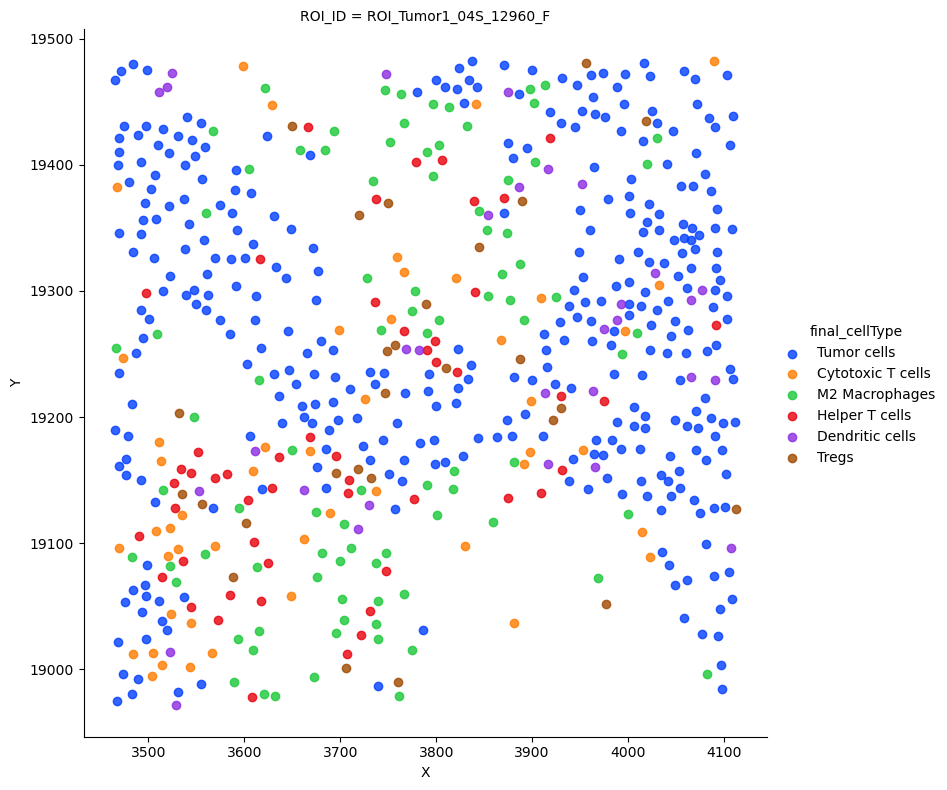

In [120]:
subset = cells[cells['ROI_ID'] == 'ROI_Tumor1_04S_12960_F']
# Coordinates of the top left corner of the region
x_min, y_min = 3465, 18972  # Replace with your values

# Width and height of the region
width, height = 649, 510  # Replace with your values

# Calculate the bounds of the region
x_max = x_min + width
y_max = y_min + height

subset = subset[
    (subset['X'] >= x_min) & (subset['X'] <= x_max) &
    (subset['Y'] >= y_min) & (subset['Y'] <= y_max)
]

# filter subset to only include cells of interest
subset = subset[subset['final_cellType'].isin(['Dendritic cells', 'Cytotoxic T cells', 'Tregs', 
                                               'Helper T cells', 'M2 Macrophages',
                                               'Negative_both', 'Only STING+', 'Only ERAP1+', 
                                               'Positive_both'])]

# replace certain cell types with more general cell types
subset['final_cellType'] = subset['final_cellType'].replace(['Negative_both', 'Only STING+', 'Only ERAP1+', 
                                               'Positive_both'], ['Tumor cells', 'Tumor cells', 'Tumor cells',
                                                                  'Tumor cells'])

sns.lmplot(data = subset,x = 'X',y='Y',hue = 'final_cellType',
           palette = 'bright',height = 8,col = reg,fit_reg = False)



In [ ]:
# make a dictionary of the ROI and its primary recurrent cell type
ROI_celltype = {'ROI_Tumor2_S13_06243_D2': 'Recurrent',
                'ROI_Tumor1_S13_06243_D2': 'Recurrent',
                'ROI_Tumor1_S14_13438_C3': 'Recurrent',
                'ROI_Tumor1_S12_26140_A4':'Primary',
                'ROI_Tumor1_S02_26957_H': 'Recurrent',
                'ROI_Tumor1_03S_4794_N': 'Recurrent',
                'ROI_Tumor1_S13_11021_A2': 'Recurrent',
                'ROI_Tumor1_S06_05608_B5': 'Primary',
                'ROI_Tumor1_03S_10865_H': 'Primary',
                'ROI_Tumor1_S10_20753_F3': 'Primary',
                'ROI_Tumor1_S08_33787_A1': 'Primary',
                'ROI_Tumor2_S09_46270_C7': 'Primary',
                'ROI_Tumor1_S09_46270_C7': 'Primary', 'ROI_Tumor1_99S_16874_G':'Primary',
                'ROI_Tumor1_S13_32894_G1':'Recurrent', 'ROI_Tumor2_S14_15257_F1':'Recurrent',
                'ROI_Tumor1_S14_15257_F1':'Recurrent', 'ROI_Tumor1_01S_1711_E':'Primary',
                'ROI_Tumor3_S07_30599_H1':'Recurrent', 'ROI_Tumor1_S07_30599_H1':'Recurrent',
                'ROI_Tumor2_S07_30599_H1':'Recurrent', 'ROI_Tumor1_S01_573_E':'Primary',
                'ROI_Tumor1_S08_15518_B13':'Primary', 'ROI_Tumor1_S07_30269_F2':'Recurrent',
                'ROI_Tumor2_S07_30269_F2':'Recurrent', 'ROI_Tumor1_S07_03744_B1':'Primary',
                'ROI_Tumor1_S10_26449_A3':'Primary', 'ROI_Tumor1_S09_03901_F1':'Recurrent',
                'ROI_Tumor1_04S_12960_F':'Primary'}
ROI_celltype

# add a column to the cells dataframe that indicates whether the cell is in a primary or recurrent tumor using ROI_celltype dictionary
cells['Tumor_type'] = cells['ROI_ID'].map(ROI_celltype)
print(cells['Tumor_type'].value_counts())

# paste two columns together to get a unique identifier for each cell
cells['prim_HRD'] = cells['groups'] + '_' + cells['Tumor_type']
cells.head()


In [ ]:
fc = cells.groupby(['patients','prim_HRD']).apply(lambda x: x['neighborhood15'].value_counts(sort = False,normalize = True))
# sum up each row to get the total number of cells in each tissue
fc

In [ ]:
fc.columns = range(15)
melt = pd.melt(fc.reset_index(),id_vars = ['patients','prim_HRD'])
melt

In [ ]:
melt = melt.rename(columns = {'variable':'neighborhood','value':'frequency of neighborhood'})
melt

In [ ]:
pivot_df = melt.pivot_table(index=['prim_HRD'], columns='neighborhood', values='frequency of neighborhood', fill_value=0)
pivot_df

In [ ]:
#plot for each group and each patient the percent of total cells allocated to each neighborhood
#fc = cells.groupby(['tissue','prim_HRD']).apply(lambda x: x['neighborhood15'].value_counts(sort = False,normalize = True))
# Pivot the DataFrame to get neighborhoods as columns

# Reset the index to make 'patients' and 'tissue' as columns
pivot_df.reset_index(inplace=True)



# Plotting
plt.figure(figsize=(12, 6))  # Adjust the size as needed
pivot_df.plot(kind='bar', stacked=True, x='prim_HRD', figsize=(12,6), colormap='tab20')

# Enhance the plot
plt.xlabel('HRD/HRP differences')
plt.ylabel('Frequency of Neighborhood')
plt.title('Stacked Frequency of Neighborhoods by HRD status')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
# Plotting code here (e.g., your bar plot code)

# Adjust the alignment of x-axis labels
ax = plt.gca()  # Get current axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)  # Rotate the labels (if needed)
    tick.set_ha('right')  # Set horizontal alignment to 'right'

# Rest of your plot customization (like setting title, labels, etc.)

plt.tight_layout()
plt.show()



In [ ]:
# save melt to csv
melt.to_csv('NN_K5n15_patients_melt_122623.csv', index=False)

In [ ]:
# find out datatype of pivot_df


# split the prim_HRD column into two columns
melt[['HRD_status','Tumor_type']] = melt['prim_HRD'].str.split('_',expand=True)
melt



In [ ]:

f,ax = plt.subplots(figsize = (10,5))
sns.stripplot(data = melt, hue = 'Tumor_type',dodge = True,alpha = .2,x ='neighborhood', y ='frequency of neighborhood')
sns.pointplot(data=melt, markers='d', hue='Tumor_type', dodge=.5, join=False, x='neighborhood', y='frequency of neighborhood')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups",
          handletextpad=0, columnspacing=1,
          loc="upper left", ncol=3, frameon=True)

In [ ]:
#t-test to evaluate if any neighborhood is enriched in one group
from scipy.stats import ttest_ind
for i in range(15):
    n2 = melt[melt['neighborhood']==i]
    print (i,'    ',ttest_ind(n2[n2['Tumor_type']=='Primary']['frequency of neighborhood'],n2[n2['Tumor_type']=='Recurrent']['frequency of neighborhood']))

In [ ]:
#plot for each group and each patient the percent of total cells allocated to each neighborhood
fc = cells.groupby(['patients', 'tissue']).apply(lambda x: x['neighborhood10'].value_counts(sort = False,normalize = True))

fc.columns = range(10)
melt = pd.melt(fc.reset_index(),id_vars = ['patients','tissue'])
melt = melt.rename(columns = {'variable':'neighborhood','value':'frequency of neighborhood'})

In [ ]:
cells[cells['ROI_ID']=='ROI_Tumor2_S13_06243_D2']

In [ ]:
# Pivot the DataFrame to get neighborhoods as columns
pivot_df = melt.pivot_table(index=['patients', 'tissue'], columns='neighborhood', values='frequency of neighborhood', fill_value=0)

# Reset the index to make 'patients' and 'tissue' as columns
pivot_df.reset_index(inplace=True)

# Optional: Create a combined 'patient_tissue' column if desired
pivot_df['patient_tissue'] = pivot_df['patients'] + "_" + pivot_df['tissue']




In [ ]:
# Plotting
plt.figure(figsize=(12, 6))  # Adjust the size as needed
pivot_df.plot(kind='bar', stacked=True, x='patient_tissue', figsize=(12,6))

# Enhance the plot
plt.xlabel('Patient and Tissue ID')
plt.ylabel('Frequency of Neighborhood')
plt.title('Stacked Frequency of Neighborhoods by Patient and Tissue')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
# Plotting code here (e.g., your bar plot code)

# Adjust the alignment of x-axis labels
ax = plt.gca()  # Get current axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)  # Rotate the labels (if needed)
    tick.set_ha('right')  # Set horizontal alignment to 'right'

# Rest of your plot customization (like setting title, labels, etc.)

plt.tight_layout()
plt.show()



In [ ]:
cells

In [ ]:
#plot for each group and each patient the percent of total cells allocated to each neighborhood
fc = cells.groupby(['groups']).apply(lambda x: x['neighborhood15'].value_counts(sort = False,normalize = True))

fc.columns = range(15)
melt = pd.melt(fc.reset_index(),id_vars = ['groups'])
melt = melt.rename(columns = {'variable':'neighborhood','value':'frequency of neighborhood'})

# Pivot the DataFrame to get neighborhoods as columns
pivot_df = melt.pivot_table(index=['groups'], columns='neighborhood', values='frequency of neighborhood', fill_value=0)

# Reset the index to make 'patients' and 'tissue' as columns
pivot_df.reset_index(inplace=True)



# Plotting
plt.figure(figsize=(12, 6))  # Adjust the size as needed
pivot_df.plot(kind='bar', stacked=True, x='groups', figsize=(12,6))

# Enhance the plot
plt.xlabel('HRD/HRP differences')
plt.ylabel('Frequency of Neighborhood')
plt.title('Stacked Frequency of Neighborhoods by HRD status')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
# Plotting code here (e.g., your bar plot code)

# Adjust the alignment of x-axis labels
ax = plt.gca()  # Get current axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)  # Rotate the labels (if needed)
    tick.set_ha('right')  # Set horizontal alignment to 'right'

# Rest of your plot customization (like setting title, labels, etc.)

plt.tight_layout()
plt.show()



In [ ]:
#plot for each group and each patient the percent of total cells allocated to each neighborhood
fc = cells.groupby(['groups']).apply(lambda x: x['neighborhood10'].value_counts(sort = False,normalize = True))

fc.columns = range(10)
melt = pd.melt(fc.reset_index(),id_vars = ['groups'])
melt = melt.rename(columns = {'variable':'neighborhood','value':'frequency of neighborhood'})
f,ax = plt.subplots(figsize = (10,5))
sns.stripplot(data = melt, hue = 'groups',dodge = True,alpha = .2,x ='neighborhood', y ='frequency of neighborhood')
sns.pointplot(data=melt, markers='d', hue='groups', dodge=.5, join=False, x='neighborhood', y='frequency of neighborhood')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups",
          handletextpad=0, columnspacing=1,
          loc="upper left", ncol=3, frameon=True)

In [ ]:
#t-test to evaluate if any neighborhood is enriched in one group
from scipy.stats import ttest_ind
for i in range(10):
    n2 = melt[melt['neighborhood']==i]
    print (i,'    ',ttest_ind(n2[n2['groups']=='HRD']['frequency of neighborhood'],n2[n2['groups']=='HRP']['frequency of neighborhood']))